## import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import num2date
from pyproj import Proj
import datetime as dt
from time import gmtime, strftime, strptime, localtime
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeat
from cartopy import util as cu
from scipy.ndimage import gaussian_filter
import metpy.calc as diag
from metpy.units import units
%matplotlib inline

import matplotlib.gridspec as gridspec

In [2]:
#mpl.rcParams.keys()
mpl.rcParams['lines.linestyle'] = 'solid'

In [3]:
#Provide start & end dates in YYYYMMDD/HH format (e.g., 20170314/00)
start_date = '20170314/00'
end_date = '20170315/00'

#Provide increment intervals in hours
interval_hours = 24

#====================================================================================

#Convert the start & end dates specified above to datetime objects
#Note we add the interval_hours to the end date as np.arange() creates a range up to *but not including* the end of the range
interval_hours = dt.timedelta(hours=interval_hours)
sdate = dt.datetime.strptime(start_date,'%Y%m%d/%H')
edate = dt.datetime.strptime(end_date,'%Y%m%d/%H') + interval_hours

#Load in handle to the data for the specified month
yyyymm = dt.datetime.strftime(sdate,'%Y%m')
data = data = xr.open_dataset("http://thredds.atmos.albany.edu:8080/thredds/dodsC/NCEP_NCAR/%s.gem" % (yyyymm))

In [4]:
data

<xarray.Dataset>
Dimensions:         (time: 124, lat: 73, lon: 144, PRES: 17)
Coordinates:
  * time            (time) datetime64[ns] 2017-03-01 ... 2017-03-31T18:00:00
  * lat             (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * lon             (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * PRES            (PRES) float64 1e+03 925.0 850.0 700.0 ... 30.0 20.0 10.0
Data variables: (12/13)
    latLonCoordSys  |S64 ...
    TMPK_PRES       (time, PRES, lat, lon) float32 ...
    PRES_NONE       (time, lat, lon) float32 ...
    UREL_PRES       (time, PRES, lat, lon) float32 ...
    OMEG_PRES       (time, PRES, lat, lon) float32 ...
    PRXX_NONE       (time, lat, lon) float32 ...
    ...              ...
    AVOR_PRES       (time, PRES, lat, lon) float32 ...
    RELH_PRES       (time, PRES, lat, lon) float32 ...
    VREL_PRES       (time, PRES, lat, lon) float32 ...
    PWTR_NONE       (time, lat, lon) float32 ...
    HGHT_PRES       (time, PRES, lat, lon) float32 ...
    HGHT_NONE       (time, lat, lon) float32 ...
Attributes:
    Conventions:              CF-1.4
    title:                    GRID data
    history:                  Direct read of GEMPAK into NetCDF-Java 4 API
    featureType:              GRID
    file_format:              GEMPAK
    location:                 /ncep/ncep_ncar/201703.gem
    _CoordinateModelRunDate:  2017-03-01T00:00:00Z
    DODS.strlen:              0

In [5]:
#Create a Lambert conformal projection object, centered over the US
lon1 = -98.5
lat1 = 38.
slat = 38.
proj_lcc = ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat])

#Define geographic bounds for plot & data subsetting (this domain covers North America)
lonW,lonE,latS,latN = [-150+360, -45+360, 15, 70]

#Choose pressure level
level = 850

#Subset data by time, pressure level, latitude & longitude
#Hint: You'll want to create a range of latitudes and longitudes using the geographic bounds defined above
dates = np.arange(sdate,edate,interval_hours) #Create a range of dates using the time interval previously specified
data_subset = data.sel(time=dates,PRES=level,lat=slice(latS,latN),lon=slice(lonW,lonE))

#Check the content of the subset data array to ensure it's what we want
#Output below should contain 3 dimensions (time, latitude, longitude)
data_subset

<xarray.Dataset>
Dimensions:         (time: 2, lat: 23, lon: 43)
Coordinates:
  * time            (time) datetime64[ns] 2017-03-14 2017-03-15
  * lat             (lat) float64 15.0 17.5 20.0 22.5 ... 62.5 65.0 67.5 70.0
  * lon             (lon) float64 210.0 212.5 215.0 217.5 ... 310.0 312.5 315.0
    PRES            float64 850.0
Data variables: (12/13)
    latLonCoordSys  |S64 b'0'
    TMPK_PRES       (time, lat, lon) float32 ...
    PRES_NONE       (time, lat, lon) float32 ...
    UREL_PRES       (time, lat, lon) float32 ...
    OMEG_PRES       (time, lat, lon) float32 ...
    PRXX_NONE       (time, lat, lon) float32 ...
    ...              ...
    AVOR_PRES       (time, lat, lon) float32 ...
    RELH_PRES       (time, lat, lon) float32 ...
    VREL_PRES       (time, lat, lon) float32 ...
    PWTR_NONE       (time, lat, lon) float32 ...
    HGHT_PRES       (time, lat, lon) float32 ...
    HGHT_NONE       (time, lat, lon) float32 ...
Attributes:
    Conventions:              CF-1.4
    title:                    GRID data
    history:                  Direct read of GEMPAK into NetCDF-Java 4 API
    featureType:              GRID
    file_format:              GEMPAK
    location:                 /ncep/ncep_ncar/201703.gem
    _CoordinateModelRunDate:  2017-03-01T00:00:00Z
    DODS.strlen:              0

## Step 3: Loop through data & generate plots

Loop through the subset data object and generate the desired plot for each time step.

Plotting time stamp 2017-03-14 00:00:00
Plotting time stamp 2017-03-15 00:00:00


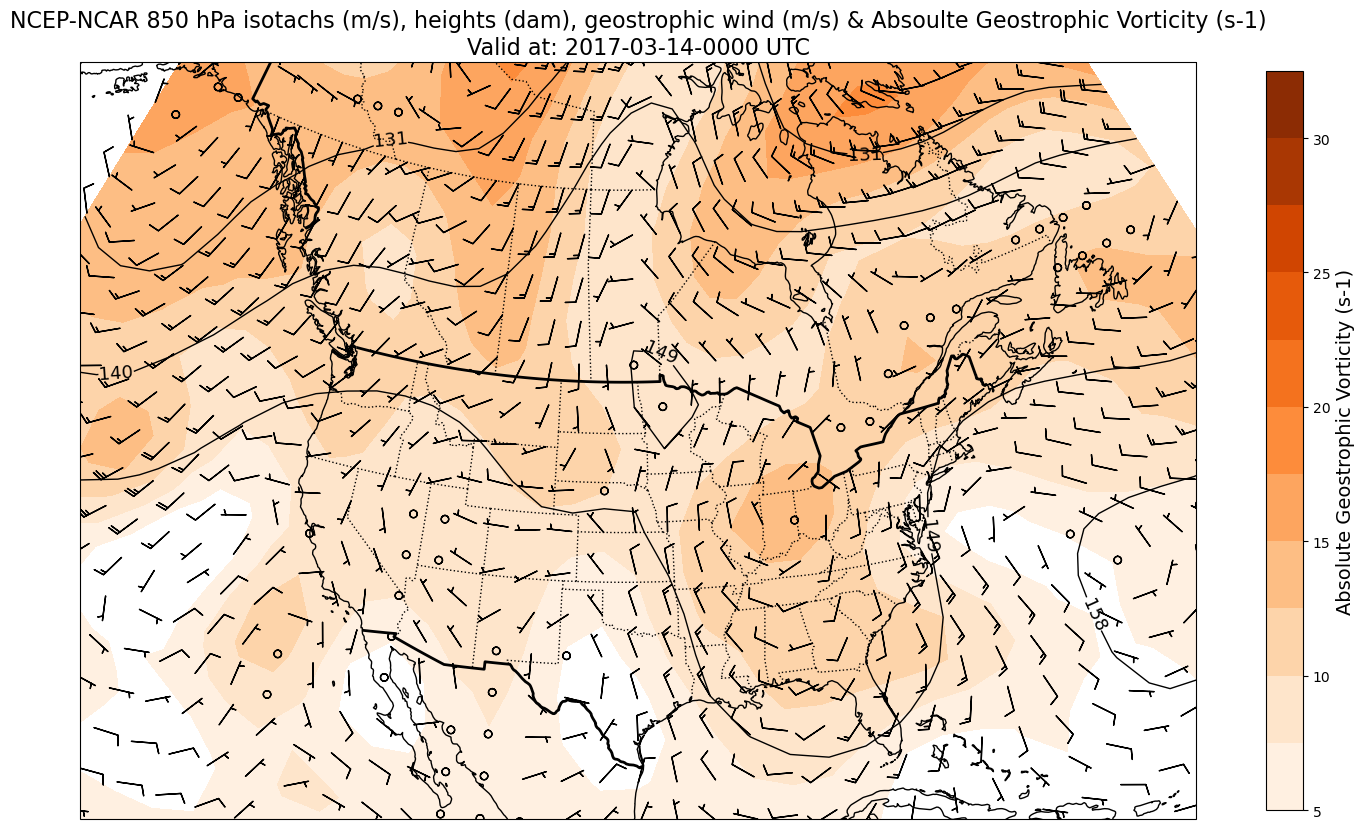

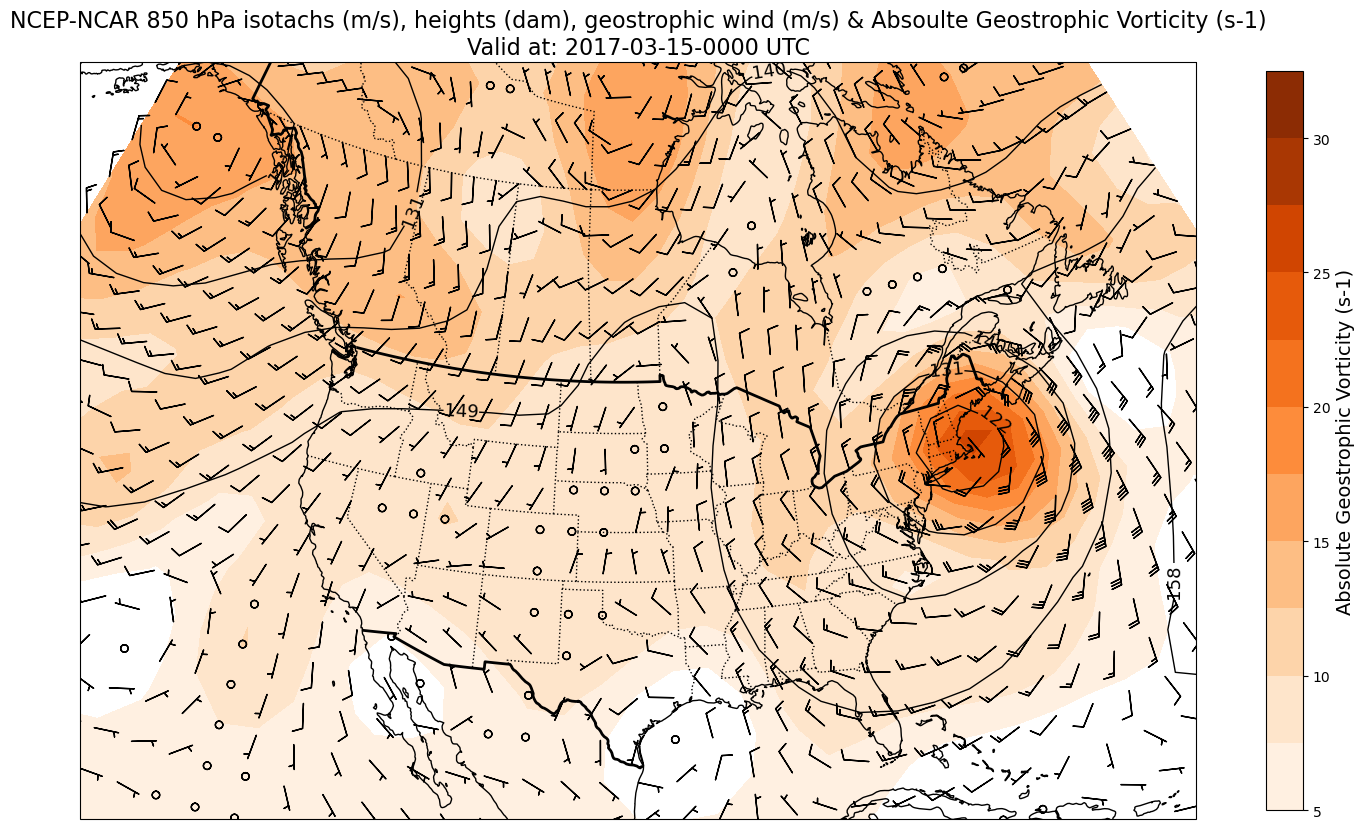

In [6]:
# 850hPa Geopotential Heights & Geostrophic Absolute Vorticity

#Plotted vorticity variable scaled by X 10^5

lat = data_subset.lat.values
lon = data_subset.lon.values
times = pd.to_datetime(data_subset.time.values)

for time_step in times:
    
    #Check current time stamp
    print(f"Plotting time stamp {time_step}")
    
    #Create figure and axis
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(1,1,1,projection=proj_lcc)
    ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
    
    #Add geography features (coastlines, countries, states, etc.)
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none')
    ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')

    u = data_subset.UREL_PRES.sel(time=time_step)
    u = u.values * units('m/s')
    v = data_subset.VREL_PRES.sel(time=time_step)    
    v = v.values * units('m/s')
    g = data_subset.HGHT_PRES.sel(time=time_step)
    g = g.values * units('m')
    vort = data_subset.AVOR_PRES.sel(time=time_step)
    vort = vort.values * units('s-1')

    # Winds
    wind = diag.wind_speed(u, v)
    ax.barbs(lon, lat, u.m, v.m, transform=ccrs.PlateCarree(), length=6,zorder=4)

    # Heights
    hght = g/10 
    cint = np.arange(50,2000,9)
    CS = ax.contour(lon,lat,hght,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree(),zorder = 2)
    ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')
    
    # Absolute Geostrophic Vorticity
    lon2d,lat2d = np.meshgrid(lon,lat)
    lat2d_for_coriolis = np.radians(lat2d)
    coriolis = diag.coriolis_parameter(np.radians(lat2d))
    dx,dy = diag.lat_lon_grid_deltas(lon,lat)
    vort_range = np.arange(5, 35, 2.5)
    vort_contourf = ax.contourf(lon, lat, vort*10**5, vort_range, cmap = plt.get_cmap('Oranges'), transform=ccrs.PlateCarree())
    cbar = fig.colorbar(vort_contourf,shrink=0.8)
    cbar.set_label('Absolute Geostrophic Vorticity (s-1)', fontsize = 14)

    #Create plot title
    valTime = time_step.strftime("%Y-%m-%d-%H%M UTC")
    tl1 = str("NCEP-NCAR " + str(level)+ " hPa isotachs (m/s), heights (dam), geostrophic wind (m/s) & Absoulte Geostrophic Vorticity (s-1)")
    tl2 = str('Valid at: '+valTime)
    plt.title(tl1+'\n'+tl2,fontsize=16)

    #Save or show figure
    fname = time_step.strftime("%Y%m%d%H")
    plt.savefig(fname+'850',dpi=125)


Plotting time stamp 2017-03-14 00:00:00


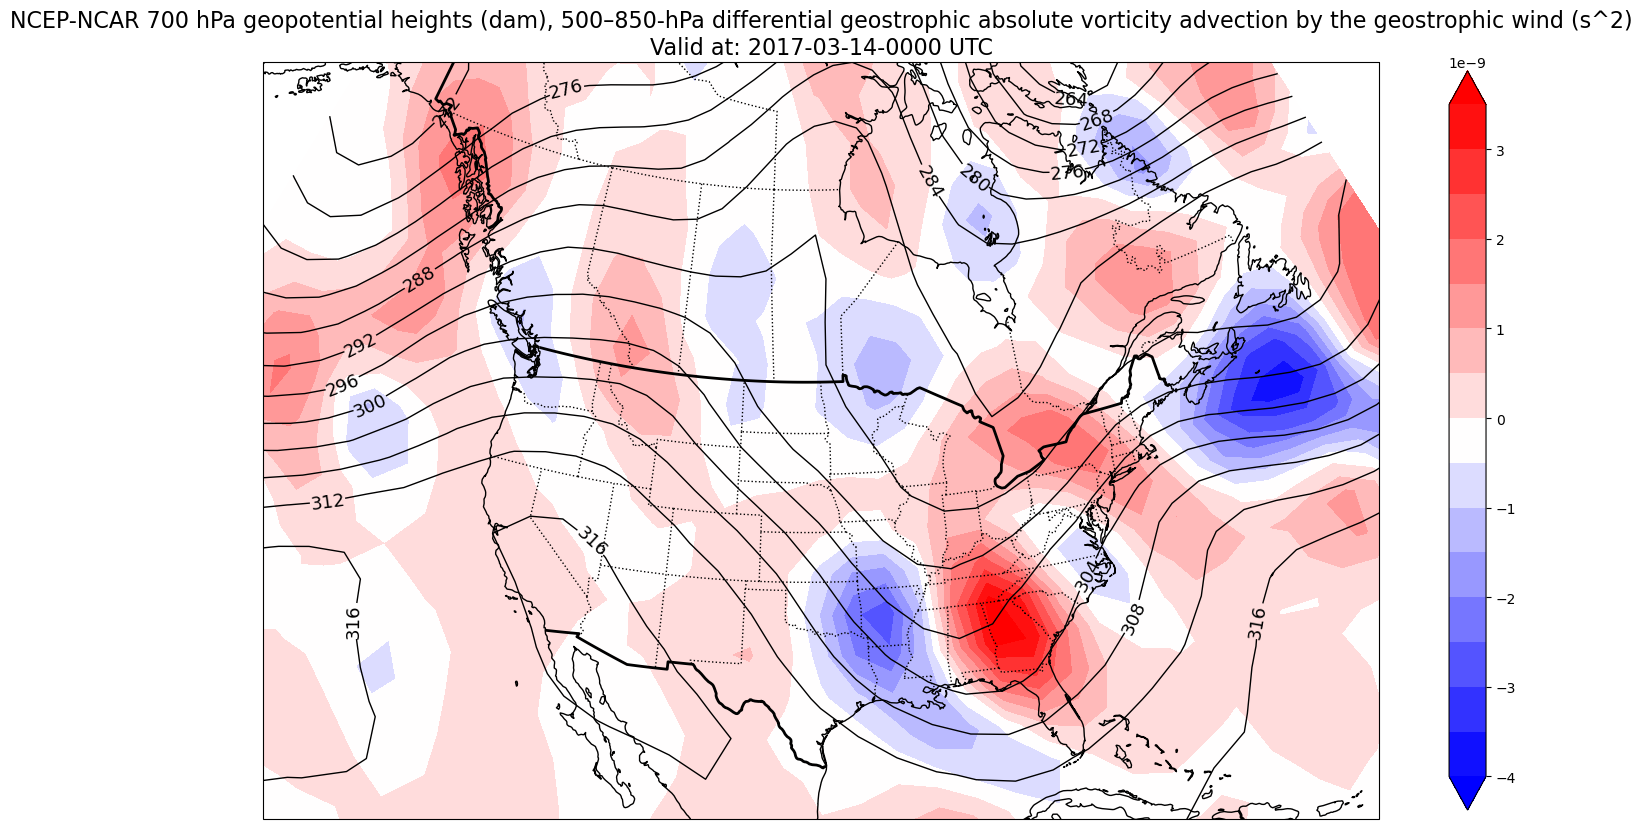

Plotting time stamp 2017-03-15 00:00:00


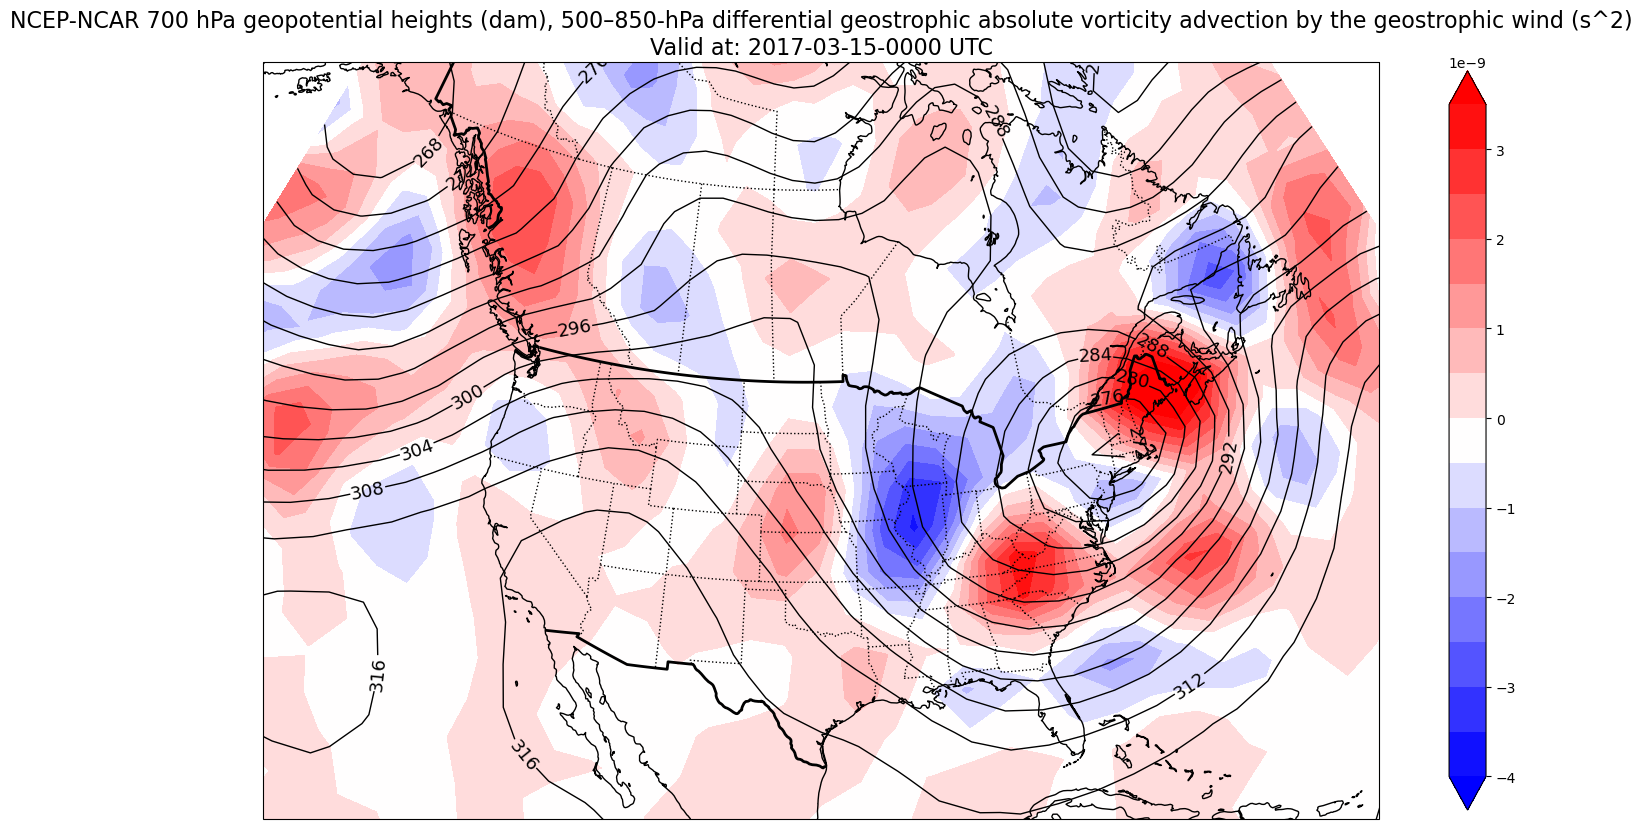

In [15]:
# Set Data Subsets at all pressure levels of interest.
data_subset700 = data.sel(time=dates,PRES=700,lat=slice(latS,latN),lon=slice(lonW,lonE))
data_subset850 = data.sel(time=dates,PRES=850,lat=slice(latS,latN),lon=slice(lonW,lonE))
data_subset500 = data.sel(time=dates,PRES=500,lat=slice(latS,latN),lon=slice(lonW,lonE))

lat = data_subset700.lat.values
lon = data_subset700.lon.values
times = pd.to_datetime(data_subset700.time.values)

for time_step in times:
    
    #Check current time stamp
    print(f"Plotting time stamp {time_step}")
    
    #Create figure and axis
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(1,1,1,projection=proj_lcc)
    ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
    
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lines',
                             scale='50m', facecolor='none')
    ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')
    
    u85 = data_subset850.UREL_PRES.sel(time=time_step)
    v85 = data_subset850.VREL_PRES.sel(time=time_step)
    u5 = data_subset500.UREL_PRES.sel(time=time_step)
    v5 = data_subset500.VREL_PRES.sel(time=time_step)
    g7 = data_subset700.HGHT_PRES.sel(time=time_step)
    g85 = data_subset500.HGHT_PRES.sel(time=time_step)
    g5 = data_subset850.HGHT_PRES.sel(time=time_step)
    
    u85 = u85.values * units('m/s')
    v85 = v85.values * units('m/s')
    u5 = u5.values * units('m/s')
    v5 = v5.values * units('m/s')
    g7 = g7.values * units('m')
    g85 = g85.values * units('m')
    g5 = g5.values * units('m')
    
    #Convert height from m to dam
    hght = g7.to('dam')
    hght85 = g85.to('dam')
    hght85_m = g85.to('m')
    hght5 = g5.to('dam')
    hght5_m = g5.to('m')
    
    #Plot height contours & labels
    cint = np.arange(4,600,4)
    CS = ax.contour(lon,lat,hght,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
    ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')

    #Convert 1D latitude and longitude arrays to 2 dimensions
    lon2d,lat2d = np.meshgrid(lon,lat)
    
    #Convert the latitude array from degrees to radians such that it can be used to calculate coriolis.
    lat2d_for_coriolis = np.radians(lat2d)
    
    #Calculate the coriolis force at all gridpoints, and horizontal distance between gridpoints
    coriolis = diag.coriolis_parameter(np.radians(lat2d))
    dx,dy = diag.lat_lon_grid_deltas(lon,lat)
    
    u_geo5, v_geo5 = diag.geostrophic_wind(hght5_m, dx, dy, latitude = lat2d_for_coriolis) 
    u_geo85, v_geo85 = diag.geostrophic_wind(hght85_m, dx, dy, latitude = lat2d_for_coriolis) 
    
    #Calculate vorticity
    vort85 = diag.absolute_vorticity(u_geo85, v_geo85, dx, dy, latitude = lat2d_for_coriolis)
    vort5 = diag.absolute_vorticity(u_geo5, v_geo5, dx, dy, latitude = lat2d_for_coriolis)
    
    #calcuate advection
    adv85 = diag.advection(vort85, u=u_geo85, v=v_geo85, w=None, dx=dx, dy=dy, dz=None)
    adv5 = diag.advection(vort5, u=u_geo5, v=v_geo5, w=None, dx=dx, dy=dy, dz=None)
    adv = adv5-adv85
    #adv = adv85-adv5
    adv = adv*-1

    fint = np.arange(-4.0E-9,4.0E-9,0.5E-9)
    CF = ax.contourf(lon, lat, adv, transform=ccrs.PlateCarree(), cmap='bwr', levels=fint, extend='both')
    cbar = fig.colorbar(CF,shrink=0.8)
    
    #======================================================================================
    # 4. Add plot title & save figure
    #======================================================================================
    
    #Create plot title
    valTime = time_step.strftime("%Y-%m-%d-%H%M UTC")
    tl1 = str("NCEP-NCAR " + str(level)+ " hPa geopotential heights (dam), 500–850-hPa differential geostrophic absolute vorticity advection by the geostrophic wind (s^2)")
    tl2 = str('Valid at: '+valTime)
    plt.title(tl1+'\n'+tl2,fontsize=16)
    
    #Save or show figure
    fname = time_step.strftime("%Y%m%d%H")
    #plt.savefig(fname,dpi=125)
    plt.show()
    
    #Close figure
    plt.close()

Plotting time stamp 2017-03-14 00:00:00


/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Plotting time stamp 2017-03-15 00:00:00


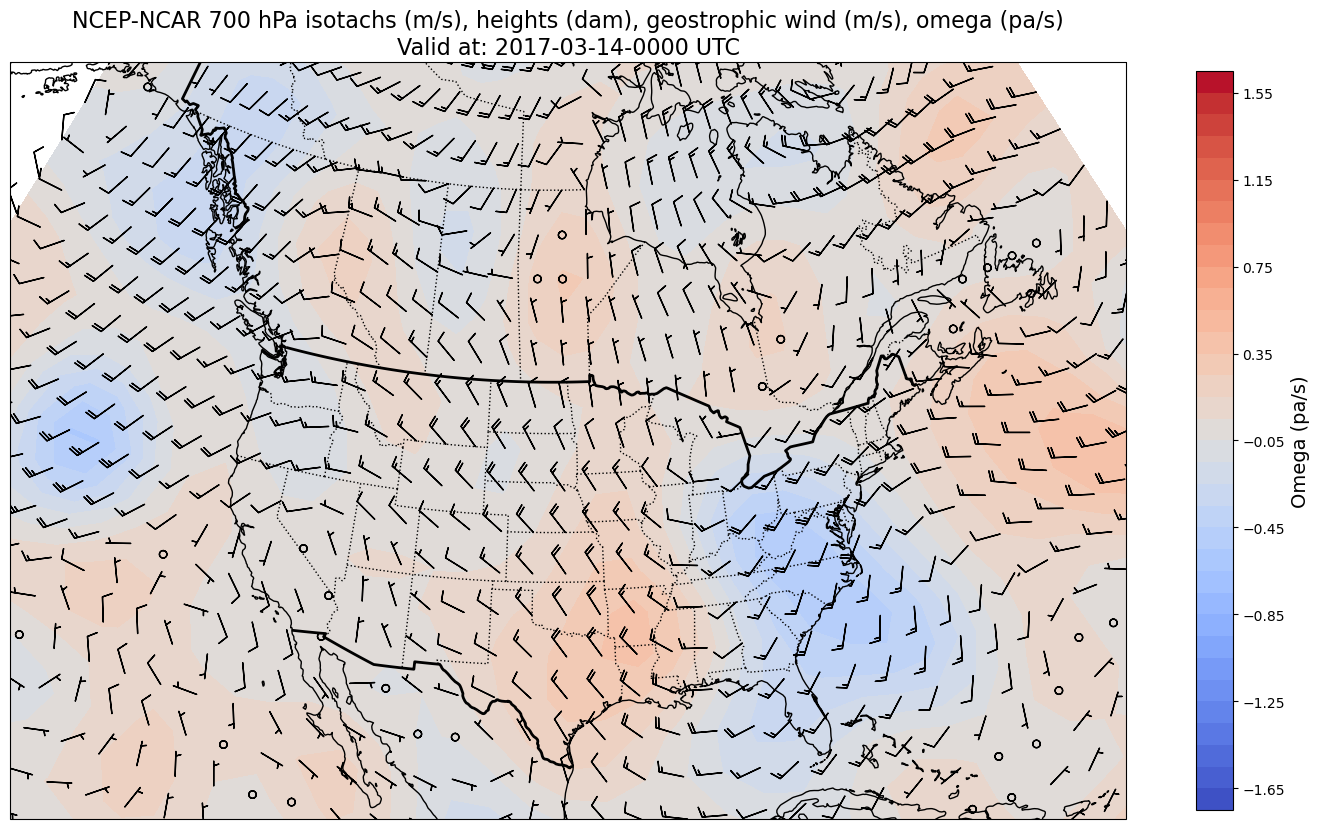

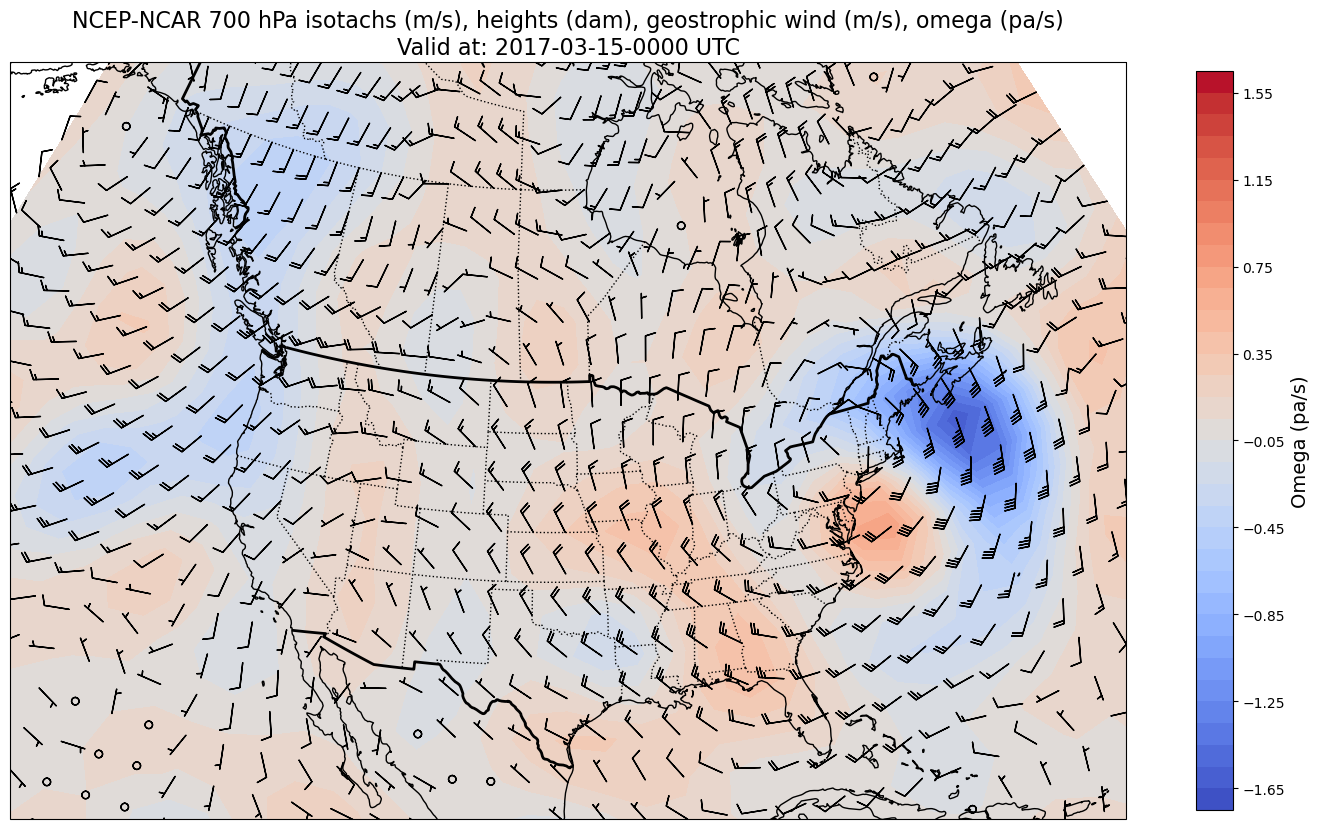

In [8]:
# 700hPa Geopotential Heights & Omega

#Choose pressure level
level = 700

#Subset data by time, pressure level, latitude & longitude
#Hint: You'll want to create a range of latitudes and longitudes using the geographic bounds defined above
dates = np.arange(sdate,edate,interval_hours) #Create a range of dates using the time interval previously specified
data_subset = data.sel(time=dates,PRES=level,lat=slice(latS,latN),lon=slice(lonW,lonE))


#Get lats, lons, and time steps for the subset data
#Recall from ATM 350 that you load variables into memory by adding ".values"
#(e.]pg., to load a variable called "temp", type "data_subset.temp.values")
lat = data_subset.lat.values
lon = data_subset.lon.values
times = pd.to_datetime(data_subset.time.values)

#Loop through date range
for time_step in times:
    
    #Check current time stamp
    print(f"Plotting time stamp {time_step}")
    
    #Create figure and axis
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(1,1,1,projection=proj_lcc)
    ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
    
    #Add geography features (coastlines, countries, states, etc.)
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none')
    ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')

    u = data_subset.UREL_PRES.sel(time=time_step)
    u = u.values * units('m/s')
    v = data_subset.VREL_PRES.sel(time=time_step)    
    v = v.values * units('m/s')
    g = data_subset.HGHT_PRES.sel(time=time_step)
    g = g.values * units('m')
    w = data_subset.OMEG_PRES.sel(time=time_step)
    w = w.values * units('pa/s')

    # Winds
    wind = diag.wind_speed(u, v)
    ax.barbs(lon, lat, u.m, v.m, transform=ccrs.PlateCarree(), length=6,zorder=4)

    # Heights
    hght = g/10 
    cint = np.arange(50,250,9)
    CS = ax.contour(lon,lat,hght,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
    ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')

    # Omega
    omega_range = np.arange(-1.75, 1.75, .1)
    omega = ax.contourf(lon, lat, w, omega_range, cmap = plt.get_cmap('coolwarm'), transform=ccrs.PlateCarree())
    cbar = fig.colorbar(omega,shrink=0.8)
    cbar.set_label('Omega (pa/s)', fontsize = 14)
    
    #Create plot title
    valTime = time_step.strftime("%Y-%m-%d-%H%M UTC")
    tl1 = str("NCEP-NCAR " + str(level)+ " hPa isotachs (m/s), heights (dam), geostrophic wind (m/s), omega (pa/s)")
    tl2 = str('Valid at: '+valTime)
    plt.title(tl1+'\n'+tl2,fontsize=16)
    
    #Save or show figure
    fname = time_step.strftime("%Y%m%d%H")
    plt.savefig(fname+'700(2)',dpi=125)

England, John